In [1]:
import torch
def supports_flash_attention(device_id):
    """Check if a GPU supports FlashAttention."""
    major, minor = torch.cuda.get_device_capability(device_id)
    
    # Check if the GPU architecture is Ampere (SM 8.x) or newer (SM 9.0)
    is_sm8x = major == 8 and minor >= 0
    is_sm90 = major == 9 and minor == 0

    return is_sm8x or is_sm90


supports_flash_attention(0),supports_flash_attention(1)

(False, False)

In [2]:
# !pip install transformers==4.47.0
# del model_name

In [3]:
!pip install -q datasets flash_attn timm einops peft wandb deepspeed accelerate bitsandbytes decord tensorboardX gdown transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!git clone https://github.com/HTAnh2003/Vintern
%cd Vintern

Cloning into 'Vintern'...
remote: Enumerating objects: 2345, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2345 (delta 2), reused 1 (delta 1), pack-reused 2338 (from 2)
Receiving objects: 100% (2345/2345), 36.45 MiB | 29.34 MiB/s, done.
Resolving deltas: 100% (1337/1337), done.
/kaggle/working/Vintern


In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

In [6]:
from huggingface_hub import login
login(HF_TOKEN)

In [7]:
!mkdir -p pretrained
%cd pretrained/
# Download 5CD-AI/Vintern-1B-v3_5 ---- finetune from InternVL2.5-1B
# !huggingface-cli download --resume-download --local-dir-use-symlinks False TienAnh/Vintern_1B_v3_5_finetune_lora_viet_chart_vqa --local-dir Vintern-1B-v3_5
!huggingface-cli download --resume-download --local-dir-use-symlinks False 5CD-AI/Vintern-1B-v3_5 --local-dir Vintern-1B-v3_5

/kaggle/working/Vintern/pretrained
/usr/local/lib/python3.11/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 15 files:   0%|                                 | 0/15 [00:00<?, ?it/s]Downloading 'generation_config.json' to 'Vintern-1B-v3_5/.cache/huggingface/download/3EVKVggOldJcKSsGjSdoUCN1AyQ=.cd9a20c20b3f0f173cff8cae0392521c06342afa.incomplete'

generation_config.json: 100%|███████████████████| 129/129 [00:00<00:00, 857kB/s]
Download complete. Moving file to Vintern-1B-v3_5/generation_config.json

configuration_intern_vit.py: 100%|█████████| 5.55k/5.55k [00:00<00

In [8]:
ls /kaggle/working/Vintern/pretrained/Vintern-1B-v3_5/

added_tokens.json               modeling_intern_vit.py
config.json                     modeling_internvl_chat.py
configuration_intern_vit.py     model.safetensors
configuration_internvl_chat.py  README.md
conversation.py                 special_tokens_map.json
generation_config.json          tokenizer_config.json
merges.txt                      vocab.json


In [9]:
## Do not use flash attention if your device not support
import json
with open('/kaggle/working/Vintern/pretrained/Vintern-1B-v3_5/config.json', 'r') as f:
    config = json.load(f)
config["vision_config"]["use_flash_attn"] = False
with open('/kaggle/working/Vintern/pretrained/Vintern-1B-v3_5/config.json', 'w') as f:
    json.dump(config, f)

In [10]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
cd /kaggle/working/Vintern

/kaggle/working/Vintern


In [12]:
import os
from tqdm import tqdm

In [13]:
import json

with open('/kaggle/input/vitextvqa/ViTextVQA_train.json', 'r') as file:
    data = json.load(file)
print(data.keys())
data['images'][:5], data['annotations'][:5]

dict_keys(['images', 'annotations'])


([{'id': 9067, 'filename': '9067.jpg'},
  {'id': 6736, 'filename': '6736.jpg'},
  {'id': 13591, 'filename': '13591.jpg'},
  {'id': 6755, 'filename': '6755.jpg'},
  {'id': 14836, 'filename': '14836.jpg'}],
 [{'id': 1,
   'image_id': 0,
   'question': 'quán ăn này bán những món gì ?',
   'answers': ['mì quảng , bún bò huế']},
  {'id': 2,
   'image_id': 0,
   'question': 'quán ăn này bán mì gì ?',
   'answers': ['mì quảng']},
  {'id': 3,
   'image_id': 0,
   'question': 'quán ăn gì bán bún gì ?',
   'answers': ['bún bò huế']},
  {'id': 4,
   'image_id': 0,
   'question': 'quán ăn này địa chỉ ở đâu ?',
   'answers': ['13a trần quốc thảo , phường 7 , quận 3']},
  {'id': 5,
   'image_id': 1,
   'question': 'tiệm trong ảnh là tiệm gì ?',
   'answers': ['sửa xe']}])

In [14]:
data['annotations'][:5]

[{'id': 1,
  'image_id': 0,
  'question': 'quán ăn này bán những món gì ?',
  'answers': ['mì quảng , bún bò huế']},
 {'id': 2,
  'image_id': 0,
  'question': 'quán ăn này bán mì gì ?',
  'answers': ['mì quảng']},
 {'id': 3,
  'image_id': 0,
  'question': 'quán ăn gì bán bún gì ?',
  'answers': ['bún bò huế']},
 {'id': 4,
  'image_id': 0,
  'question': 'quán ăn này địa chỉ ở đâu ?',
  'answers': ['13a trần quốc thảo , phường 7 , quận 3']},
 {'id': 5,
  'image_id': 1,
  'question': 'tiệm trong ảnh là tiệm gì ?',
  'answers': ['sửa xe']}]

In [15]:
import pandas as pd

# Dữ liệu
df = pd.DataFrame(data['annotations'])

In [16]:
df.head()

,id,image_id,question,answers
0,1,0,quán ăn này bán những món gì ?,"[mì quảng , bún bò huế]"
1,2,0,quán ăn này bán mì gì ?,[mì quảng]
2,3,0,quán ăn gì bán bún gì ?,[bún bò huế]
3,4,0,quán ăn này địa chỉ ở đâu ?,"[13a trần quốc thảo , phường 7 , quận 3]"
4,5,1,tiệm trong ảnh là tiệm gì ?,[sửa xe]


In [17]:
df['len_question'] = df['question'].apply(lambda x: len(x))

In [18]:
df[df['len_question']==137]['question']

21101    trong việc ban hành và triển khai văn bản pháp...
Name: question, dtype: object

In [19]:
df['len_answer'] = df['answers'].apply(lambda x: len(x))
df.head()

,id,image_id,question,answers,len_question,len_answer
0,1,0,quán ăn này bán những món gì ?,"[mì quảng , bún bò huế]",30,1
1,2,0,quán ăn này bán mì gì ?,[mì quảng],23,1
2,3,0,quán ăn gì bán bún gì ?,[bún bò huế],23,1
3,4,0,quán ăn này địa chỉ ở đâu ?,"[13a trần quốc thảo , phường 7 , quận 3]",27,1
4,5,1,tiệm trong ảnh là tiệm gì ?,[sửa xe],27,1


In [20]:
(data['annotations'][0]['answers'])

['mì quảng , bún bò huế']

In [21]:
df['len_answer'].max()

1

In [22]:
def format_conversation(question,answer):
    return [
        {"from": "human", "value": f"<image>\n{question}"},
        {"from": "gpt", "value": answer}
    ]

In [23]:
format_conversation(data['annotations'][0]['question'],data['annotations'][0]['answers'][0])

[{'from': 'human', 'value': '<image>\nquán ăn này bán những món gì ?'},
 {'from': 'gpt', 'value': 'mì quảng , bún bò huế'}]

In [24]:
# Chuyển thành từ điển với id làm key
images_dict = {item['id']: item for item in data['images']}

# Truy xuất nhanh theo id
search_id = 0
result = images_dict.get(search_id)
result

{'id': 0, 'filename': '0.jpg'}

In [25]:
FOLDER_IMAGES = '/kaggle/input/vitextvqa/ViTextVQA_images/st_images'

In [26]:
import json
import os
from tqdm import tqdm

all_data = []

for item in tqdm(data['annotations']):
    id = item['id']
    image = f"{FOLDER_IMAGES}/{images_dict.get(item['image_id'])['filename']}"
    # width = item['image'].width
    # height = item['image'].height
    question = item['question']
    answer = item['answers'][0]
    conversations = format_conversation(question,answer)

    data_item = {
        "id": id,
        "image": image,
        # "width": width,
        # "height": height,
        "conversations": conversations
    }
    all_data.append(data_item)

print(len(all_data))
print(all_data[0:5])

100%|██████████| 35159/35159 [00:00<00:00, 118625.90it/s]

35159
[{'id': 1, 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/0.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nquán ăn này bán những món gì ?'}, {'from': 'gpt', 'value': 'mì quảng , bún bò huế'}]}, {'id': 2, 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/0.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nquán ăn này bán mì gì ?'}, {'from': 'gpt', 'value': 'mì quảng'}]}, {'id': 3, 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/0.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nquán ăn gì bán bún gì ?'}, {'from': 'gpt', 'value': 'bún bò huế'}]}, {'id': 4, 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/0.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nquán ăn này địa chỉ ở đâu ?'}, {'from': 'gpt', 'value': '13a trần quốc thảo , phường 7 , quận 3'}]}, {'id': 5, 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/1.jpg', 'conversations': [{'from': 'human', 'value': '<image>\

In [27]:
all_data[0]

{'id': 1,
 'image': '/kaggle/input/vitextvqa/ViTextVQA_images/st_images/0.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nquán ăn này bán những món gì ?'},
  {'from': 'gpt', 'value': 'mì quảng , bún bò huế'}]}

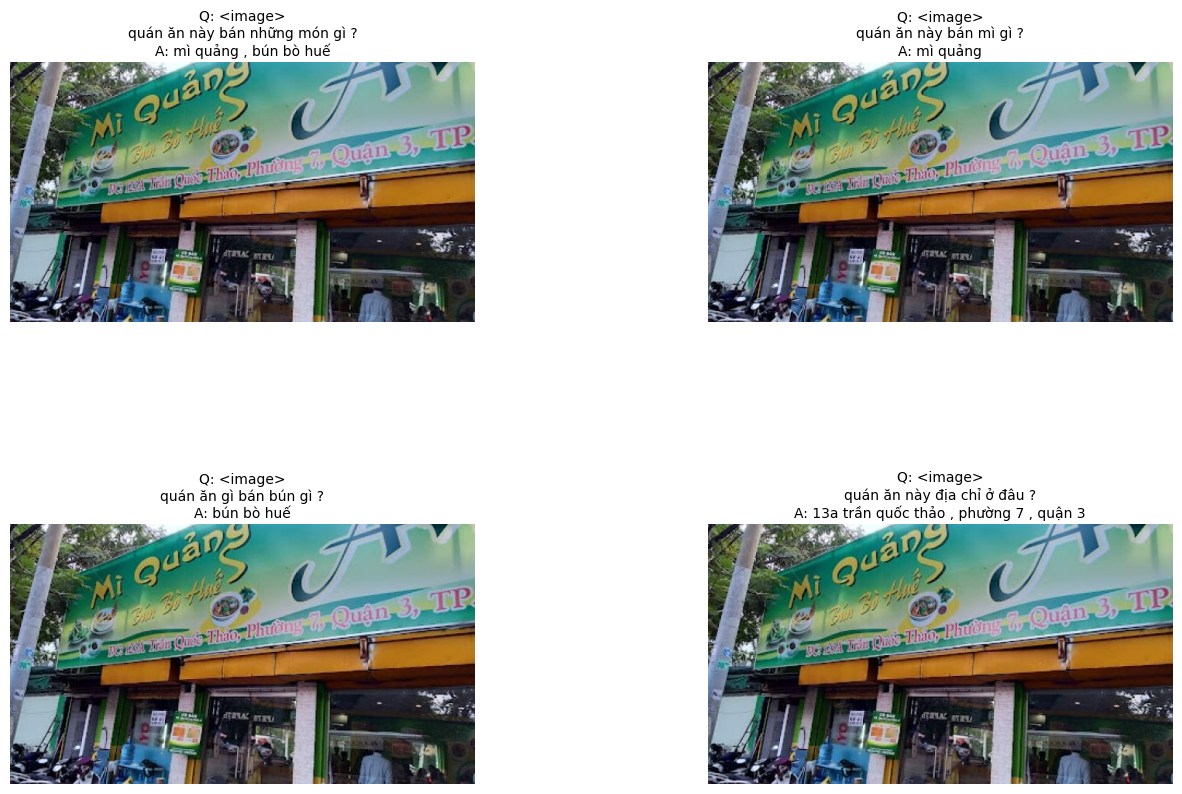

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Hàm hiển thị dữ liệu trong lưới
def visualize_grid(data, rows=3, cols=3):
    """
    Hiển thị hình ảnh và hội thoại trong lưới (grid).

    Parameters:
    - data: Danh sách chứa các phần tử với đường dẫn hình ảnh và hội thoại.
    - rows: Số hàng trong lưới (mặc định là 3).
    - cols: Số cột trong lưới (mặc định là 3).
    """
    # Tạo một figure với các ô con (subplots)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Điều chỉnh khoảng cách giữa các ô

    # Hiển thị tối đa số ảnh = rows * cols
    for ax, item in zip(axes.flat, data[:rows * cols]):
        image_path = item['image']  # Lấy đường dẫn hình ảnh
        img = mpimg.imread(image_path)  # Đọc ảnh từ đường dẫn
        ax.imshow(img)
        ax.axis('off')  # Tắt hiển thị trục

        # Lấy hội thoại (câu hỏi và trả lời)
        conversations = item['conversations']
        question = conversations[0]['value']  # Bỏ tag <image>
        answer = conversations[1]['value']

        # Đặt tiêu đề cho mỗi ô (câu hỏi và câu trả lời)
        ax.set_title(f"Q: {question}\nA: {answer}", fontsize=10, wrap=True)

    # Ẩn các ô trống nếu dữ liệu không đủ
    for ax in axes.flat[len(data):]:
        ax.axis('off')

    # Hiển thị lưới
    plt.show()

# Ví dụ gọi hàm
visualize_grid(all_data, rows=2, cols=2)

In [29]:
# import json

# all_data = []

# for item in tqdm(vi_receipt_dataset['train']):
#     # Just 500 items for example
#     if len(all_data) >= 500:
#         break
#     id = item['id']
#     image = f"{FOLDER_IMAGES}/{item['id']}.jpg"
#     width = item['image'].width
#     height = item['image'].height
#     # conversation_description = [
#     #         {"from": "human", "value": '<image>\nMô tả thông tin trong biểu đồ'},
#     #         {"from": "gpt", "value": str(item["description"])}
#     # ]
#     # data = {
#     #     "id": id,
#     #     "image": image,
#     #     "width": width,
#     #     "height": height,
#     #     "conversations": conversation_description
#     # }
#     # all_data.append(data)

#     conversations = format_conversations(item['conversations'])

#     data = {
#         "id": id,
#         "image": image,
#         "width": width,
#         "height": height,
#         "conversations": conversations
#     }
#     all_data.append(data)

# print(len(all_data))
# print(all_data[0:5])

In [30]:
### Write JSONL line
with open('/kaggle/working/Vintern/internvl_chat/shell/data/data-ViTextVQA.jsonl', 'w', encoding='utf-8') as f:
    for data in tqdm(all_data):
        f.write(json.dumps(data, ensure_ascii=False) + '\n')

100%|██████████| 35159/35159 [00:00<00:00, 136210.93it/s]


In [31]:
# !cat '/kaggle/working/Vintern/internvl_chat/shell/data/data-ViTextVQA.jsonl'

In [32]:
metadata_datasets = {
  "data-ViTextVQA": {
    "root": "/kaggle/input/vitextvqa",
    "annotation": "/kaggle/working/Vintern/internvl_chat/shell/data/data-ViTextVQA.jsonl",
    "data_augment": False,
    "repeat_time": 1,
    "length": len(all_data) 
  }
}


with open('/kaggle/working/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json', 'w', encoding='utf-8') as f:
    json.dump(metadata_datasets, f, ensure_ascii=False, indent=4)

!cat '/kaggle/working/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json'

{
    "data-ViTextVQA": {
        "root": "/kaggle/input/vitextvqa",
        "annotation": "/kaggle/working/Vintern/internvl_chat/shell/data/data-ViTextVQA.jsonl",
        "data_augment": false,
        "repeat_time": 1,
        "length": 35159
    }
}

In [33]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tienanh2003 (tienanh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [34]:
os.environ['WANDB_PROJECT'] = 'fine-tuned-vintern1B_v3_5_VQA'

In [35]:
!nvidia-smi

Fri May  9 15:45:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
# all_data[1]['conversations']

In [37]:
OUTPUT_DIR='/kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa'

In [38]:
train_bash_content = '''set -x

GPUS=${GPUS:-2}
BATCH_SIZE=${BATCH_SIZE:-16}
PER_DEVICE_BATCH_SIZE=${PER_DEVICE_BATCH_SIZE:-8}
GRADIENT_ACC=$((BATCH_SIZE / PER_DEVICE_BATCH_SIZE / GPUS))

export PYTHONPATH="${PYTHONPATH}:$(pwd)"
export MASTER_PORT=34229
export TF_CPP_MIN_LOG_LEVEL=3
export LAUNCHER=pytorch

OUTPUT_DIR='/kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa'

if [ ! -d "$OUTPUT_DIR" ]; then
  mkdir -p "$OUTPUT_DIR"
fi

# number of gpus: 2
# batch size per gpu: 4
# gradient accumulation steps: 2
# total batch size: 16
# epoch: 1
torchrun \
  --nnodes=1 \
  --node_rank=0 \
  --master_addr=127.0.0.1 \
  --nproc_per_node=${GPUS} \
  --master_port=${MASTER_PORT} \
  internvl/train/internvl_chat_finetune.py \
  --model_name_or_path "/kaggle/working/Vintern/pretrained/Vintern-1B-v3_5" \
  --conv_style "Hermes-2" \
  --output_dir ${OUTPUT_DIR} \
  --meta_path "/kaggle/working/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json" \
  --overwrite_output_dir True \
  --force_image_size 448 \
  --max_dynamic_patch 1 \
  --down_sample_ratio 0.5 \
  --drop_path_rate 0.0 \
  --freeze_llm True \
  --freeze_mlp True \
  --freeze_backbone True \
  --use_llm_lora 16 \
  --vision_select_layer -1 \
  --dataloader_num_workers 4 \
  --bf16 True \
  --num_train_epochs 1 \
  --per_device_train_batch_size ${PER_DEVICE_BATCH_SIZE} \
  --gradient_accumulation_steps ${GRADIENT_ACC} \
  --evaluation_strategy "no" \
  --save_strategy "steps" \
  --save_steps 500 \
  --save_total_limit 2 \
  --learning_rate 4e-5 \
  --weight_decay 0.01 \
  --warmup_ratio 0.03 \
  --lr_scheduler_type "cosine" \
  --logging_steps 10 \
  --max_seq_length 700 \
  --do_train True \
  --grad_checkpoint True \
  --group_by_length True \
  --dynamic_image_size True \
  --use_thumbnail True \
  --ps_version 'v2' \
  --deepspeed "zero_stage1_config.json" \
  --report_to "wandb" \
  2>&1 | tee -a "${OUTPUT_DIR}/training_log.txt"
'''

In [39]:
with open("/kaggle/working/Vintern/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh", "w") as text_file:
    text_file.write(train_bash_content)

In [40]:
# !pip show transformers
# !pip install transformers==4.47.0

In [41]:
%cd /kaggle/working/Vintern/internvl_chat
!sh shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh

/kaggle/working/Vintern/internvl_chat
+ GPUS=2
+ BATCH_SIZE=16
+ PER_DEVICE_BATCH_SIZE=8
+ GRADIENT_ACC=1
+ pwd
+ export PYTHONPATH=/kaggle/lib/kagglegym:/kaggle/lib:/kaggle/working/Vintern/internvl_chat
+ export MASTER_PORT=34229
+ export TF_CPP_MIN_LOG_LEVEL=3
+ export LAUNCHER=pytorch
+ OUTPUT_DIR=/kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa
+ [ ! -d /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa ]
+ mkdir -p /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa
+ torchrun --nnodes=1 --node_rank=0 --master_addr=127.0.0.1 --nproc_per_node=2 --master_port=34229 internvl/train/internvl_chat_finetune.py --model_name_or_path /kaggle/working/Vintern/pretrained/Vintern-1B-v3_5 --conv_style Hermes-2 --output_dir /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa --meta_path /kaggle/working/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json --overwrite_output_dir True --force_image_s

In [42]:
merge_lora_content = '''import torch
import sys
sys.path.append("/kaggle/working/Vintern/internvl_chat")
from internvl.model.internvl_chat import InternVLChatModel
from transformers import AutoTokenizer
import argparse

argparse = argparse.ArgumentParser()
argparse.add_argument("input_path", type=str, help="Path to the input model")
argparse.add_argument("output_path", type=str, help="Path to the output model")
args = argparse.parse_args()

print("Loading model...")
model = InternVLChatModel.from_pretrained(
    args.input_path, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16).eval()
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(args.input_path, trust_remote_code=True)

if model.config.use_backbone_lora:
    model.vision_model.merge_and_unload()
    model.vision_model = model.vision_model.model
    model.config.use_backbone_lora = 0
if model.config.use_llm_lora:
    model.language_model.merge_and_unload()
    model.language_model = model.language_model.model
    model.config.use_llm_lora = 0

print("Saving model...")
model.save_pretrained(args.output_path)
print("Saving tokenizer...")
tokenizer.save_pretrained(args.output_path)
print("Done!")
'''

with open("/kaggle/working/Vintern/internvl_chat/tools/merge_lora.py", "w") as text_file:
    text_file.write(merge_lora_content)

In [43]:
### If could not import internvl edit add
### import sys
### sys.path.append("/content/Vintern/internvl_chat")

%cd /kaggle/working/Vintern/internvl_chat
!python tools/merge_lora.py /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa \
                            /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa_merge

/kaggle/working/Vintern/internvl_chat
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-05-09 20:58:29.396584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746824309.421093     871 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746824309.428120     871 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
trainable params: 8,798,208 || all params: 638,496,128 || trainable%: 1.3780
Loading tokenizer...
Saving mo

In [44]:
!cp /kaggle/working/Vintern/pretrained/Vintern-1B-v3_5/*.py \
    /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa_merge

In [45]:
!cp /kaggle/working/Vintern/pretrained/Vintern-1B-v3_5/config.json \
    /kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa_merge

In [46]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    image = image.resize((input_size, input_size))

    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [47]:
## load pretrained model
model_name = "/kaggle/working/work_dirs/internvl_chat_v2_0/Vintern_1B_finetune_lora_vqa_merge"

model = AutoModel.from_pretrained(model_name,
                                  torch_dtype=torch.bfloat16,
                                  low_cpu_mem_usage=True,
                                  use_flash_attn=False,
                                  trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

configuration_internvl_chat.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

conversation.py:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
2025-05-09 20:58:50.480400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746824330.503333      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00

In [48]:
mkdir /kaggle/working/test/

In [49]:
!wget -O /kaggle/working/test/image_test.jpg https://d1j8r0kxyu9tj8.cloudfront.net/files/1693929210kPbMu3CrBIthVaQ.jpg

--2025-05-09 20:58:56--  https://d1j8r0kxyu9tj8.cloudfront.net/files/1693929210kPbMu3CrBIthVaQ.jpg
Resolving d1j8r0kxyu9tj8.cloudfront.net (d1j8r0kxyu9tj8.cloudfront.net)... 3.169.201.57, 3.169.201.133, 3.169.201.190, ...
Connecting to d1j8r0kxyu9tj8.cloudfront.net (d1j8r0kxyu9tj8.cloudfront.net)|3.169.201.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147828 (144K) [jpeg]
Saving to: ‘/kaggle/working/test/image_test.jpg’

/kaggle/working/tes 100%[===================>] 144.36K   449KB/s    in 0.3s    

2025-05-09 20:58:57 (449 KB/s) - ‘/kaggle/working/test/image_test.jpg’ saved [147828/147828]



In [ ]:
### Test samples
test_folder = '/kaggle/working/test'
for filename in os.listdir(test_folder):
    image_path = os.path.join(test_folder, filename)
    image = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens= 1024, do_sample=False, num_beams = 3, repetition_penalty=2.0)

    question = '<image>\ câu hỏi .'

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')
    print("="*30)

    question = '<image>\ .....?'
    
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')
    print("="*30)